In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import json
import requests
print(requests.__version__)
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
%matplotlib inline

2.27.1


# Loading the data and exploring high level features

In [2]:
df=pd.read_csv('data/piki_dataset_6_2022.csv')

In [3]:
df['year'] = pd.DatetimeIndex(df['timestamp']).year
df['month'] = pd.DatetimeIndex(df['timestamp']).month
df['like_superlike']=(df['liked']>0)*1

In [4]:
num_ratings=len(df)
print(num_ratings)

1017947


In [27]:
users=df.groupby('user_id').mean()['like_superlike']
songs=df.groupby('song_id').mean()['like_superlike']

In [48]:
num_users=len(users)
print(num_users)

6696


In [49]:
num_ratings/num_users

152.02314814814815

In [46]:
users.mean()

0.5231286383790986

In [50]:
num_songs=len(songs)
print(num_songs)

181663


In [51]:
num_ratings/num_songs

5.60349107963647

In [47]:
songs.mean()

0.3335244767610928

In [39]:
users_rates=df.groupby('user_id').count()['song_id']
songs_rates=df.groupby('song_id').count()['user_id']

In [42]:
len(users_rates[users_rates>10])

4940

In [43]:
len(songs_rates[songs_rates>10])

15678

# The role of the user feedback mechanism

Voting timers are introduced on 2021-01-03

Before this date, users may immediately vote like/dislike/superlike

After this date, users must wait 3s to dislike, 6s to like and 12s to superlike

In [6]:
df_pre_timers=(df[((df['timestamp']<'2021-01-03'))])

In [52]:
df_pre_timers['like_superlike'].mean()

0.4499492375160922

In [7]:
df_post_timers=(df[((df['timestamp']>='2021-01-03'))])

In [53]:
df_post_timers['like_superlike'].mean()

0.3806881365262868

average like rate went down after this feature was implemented

In [15]:
def plot_histograms(df,thresh_users,thresh_songs,bins):
    users=df.groupby('user_id').mean()['like_superlike']
    songs=df.groupby('song_id').mean()['like_superlike']
    users_rates=df.groupby('user_id').count()['song_id']
    songs_rates=df.groupby('song_id').count()['user_id']
    users[users_rates[users_rates>thresh_users].index].hist(bins=bins)
    plt.figure()
    songs[songs_rates[songs_rates>thresh_songs].index].hist(bins=bins)

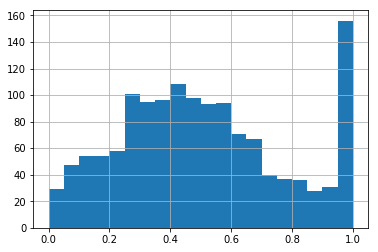

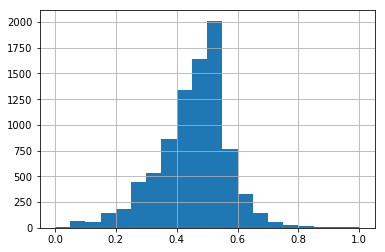

In [33]:
plot_histograms(df_pre_timers,10,10,20)

before implementing timers:
1) there is a significant proportion of users who like everything
2) the song like-ratio is peaked at 0.5

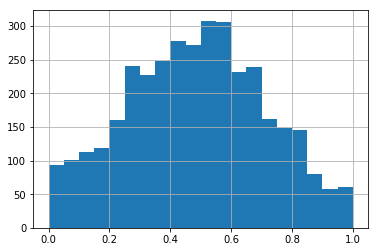

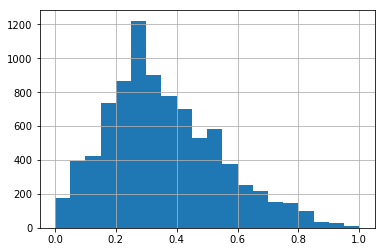

In [38]:
plot_histograms(df_post_timers,10,10,20)

after implementing timers:
1) users who like everything are greatly reduced
2) the song like-ratio is peaked at 0.25 and has a longer right tail

# The role of Spotify popularity
Songs with higher Spotify popularity are more often liked. This provides a benchmark for the liked rate of a song, given the popularity of its artist. This may help better quantify the role of popularity biases

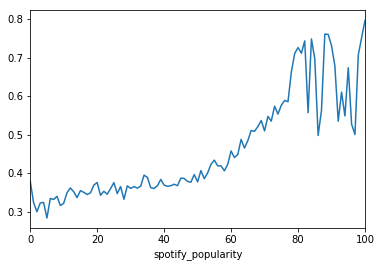

In [55]:
# all songs
df.groupby(['spotify_popularity']).mean()['liked'].plot()

# The role of recommendations based on previous ratings

Songs by artist that were previously liked (2) are better liked than personalized recommendations (1) are better liked than random recommendations (0)

This provides a benchmark for comparing obvious recommendations (2) to less obvious recommendations (1), to more suprising recommendations outside of one's echo chamber (0).

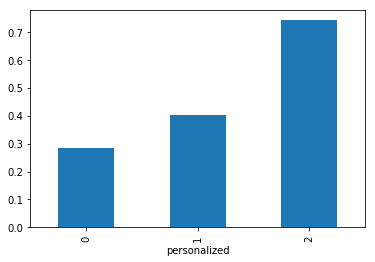

In [43]:
df.groupby(['personalized']).mean()['like_superlike'].plot.bar()